In [17]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42

In [18]:
# File saved to: ./logs/vgg16/imagenet/int8/faults_network_rb/r0.001/stats/4.pkl
def get_results_dir(model_name, dataset_name, data_type, fault_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/vgg16/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/vgg16/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/vgg16/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_adaptive': './logs/vgg16/imagenet/int8/faults_network_rb_adaptive',
                    'faults_network_rb_ecc': './logs/vgg16/imagenet/int8/faults_network_rb_ecc',
                    'faults_network_rb_bch': './logs/vgg16/imagenet/int8/faults_network_rb_bch',
                },
               
            }
        },
        'vgg16_bn': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/vgg16_bn/imagenet/int8/faults_network_rb',
                },
               
            }
        },
         'resnet18': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/resnet18/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/resnet18/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/resnet18/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/resnet18/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_adaptive': './logs/resnet18/imagenet/int8/faults_network_rb_adaptive',
                    'faults_network_rb_ecc': './logs/resnet18/imagenet/int8/faults_network_rb_ecc',
                    'faults_network_rb_bch': './logs/resnet18/imagenet/int8/faults_network_rb_bch',
                },
               
            }
        },
        'resnet34': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/resnet34/imagenet/int8/faults_network_rb',
                },
               
            }
        },
         'squeezenet': {
            'imagenet': {
                'int8': {
                    'faults_network_rb': './logs/squeezenet/imagenet/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/squeezenet/imagenet/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/squeezenet/imagenet/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_parity_avg': './logs/squeezenet/imagenet/int8/faults_network_rb_parity_avg',
                    'faults_network_rb_adaptive': './logs/squeezenet/imagenet/int8/faults_network_rb_adaptive',
                    'faults_network_rb_ecc': './logs/squeezenet/imagenet/int8/faults_network_rb_ecc',
                    'faults_network_rb_bch': './logs/squeezenet/imagenet/int8/faults_network_rb_bch',
                },
            }
        },
        'lstm':{
            'wikitext':{
                'int8':{
                    'faults_network_rb': './logs/lstm/wikitext/int8/faults_network_rb',
                    'faults_network_rb_ps1': './logs/lstm/wikitext/int8/faults_network_rb_ps1',
                    'faults_network_rb_parity_zero': './logs/lstm/wikitext/int8/faults_network_rb_parity_zero',
                    'faults_network_rb_ecc': './logs/lstm/wikitext/int8/faults_network_rb_ecc',
                }
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(data_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, data_type):
    d = {
        'vgg16': {
            'imagenet': {
                'int8': 79.36, 
              }},
        'vgg16_bn': {
            'imagenet': {
                'int8': 80.14, 
              }},
        'resnet18': {
            'imagenet': {
                'int8': 76.46, 
              }},
        'resnet34': {
            'imagenet': {
                'int8': 79.88, 
              }},
         'squeezenet': {
            'imagenet': {
                'int8': 66.86, 
              }},
        'lstm':{
            'wikitext':{
                'int8': 92.02
            }
        }
        }
        
    return d[model_name][dataset_name][data_type]


In [19]:
def parse_log(log_path):
#     trial: 4, n_faults: 1106753, total_params: 138344128, flipped_bits: 1106753 (1.00e-03), 
# changed_params: 1102905 (7.97e-03), test_time: 369, test_accuracy: 58.680000

    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item or 'perplexity' in item:
                        test_accuracy = round(float(item.split()[1]), 2)
                    if 'trial:' in item:
                        trial = int(item.split()[1])
#                         print('trial', trial)
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    print('Finish:', log_path, result.shape)
    return result 

def load_results(data_type, fault_type):
    print('load results for data type:%s, fault_type:%s' %(data_type, fault_type))
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, data_type, fault_type)
    if not results_dir:
        print('results dir does not exist for model_name:%s, dataset_name:%s, data_type:%s, fault_type:%s' 
              %(model_name, dataset_name, data_type, fault_type))
        return None 
    
    # get number of bits folder
    if 'adaptive' in fault_type:
        # when fault_type is inplace protection, it has three dimentions: fault_rate, tier1/2, config_id  
        for nbits_folder in os.listdir(results_dir):
            nbits  = float(nbits_folder[1:])
            for tier_folder in os.listdir(os.path.join(results_dir, nbits_folder)):
                for config_folder in os.listdir(os.path.join(results_dir, nbits_folder, tier_folder)):
                    log_path = os.path.join(results_dir, nbits_folder, tier_folder, config_folder, 'logs.txt')
                    config_id = int(config_folder[2:])
                    if os.path.isfile(log_path):
                        results[(nbits, tier_folder, config_id)] = parse_log(log_path)
    else:
        for nbits_folder in os.listdir(results_dir):
            nbits = float(nbits_folder[1:])
            log_path = os.path.join(results_dir, nbits_folder, 'logs.txt')
            if os.path.isfile(log_path):
                results[nbits] = parse_log(log_path)
    return results 
        



data_types = ['int8']
# dataset_name = 'imagenet'
dataset_name = 'wikitext'

# model_name = 'vgg16'
# model_name = 'resnet18'
# model_name = 'squeezenet'
model_name = 'lstm'

fault_types = ['faults_network_rb', 
               'faults_network_rb_parity_zero', 
               'faults_network_rb_ps1', 'faults_network_rb_ecc', 
              ]
#                'faults_network_rb_ps1', 'faults_network_rb_ecc', 
#                'faults_network_rb_adaptive']


# fault_types = ['faults_network_rb', 
#                'faults_network_rb_parity_zero', 'faults_network_rb_parity_avg',
#                'faults_network_rb_ps1', 'faults_network_rb_ecc',  'faults_network_rb_bch',
#                'faults_network_rb_adaptive']

data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for data_type in data_types:
    data[data_type] = {} 
    for fault_type in fault_types:
        results = load_results(data_type, fault_type)
        if results:
            data[data_type][fault_type] = results 

load results for data type:int8, fault_type:faults_network_rb
Finish: ./logs/lstm/wikitext/int8/faults_network_rb/r0.001/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb/r0.01/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb/r0.0001/logs.txt (10, 3)
load results for data type:int8, fault_type:faults_network_rb_parity_zero
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_parity_zero/r0.001/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_parity_zero/r0.01/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_parity_zero/r0.0001/logs.txt (10, 3)
load results for data type:int8, fault_type:faults_network_rb_ps1
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_ps1/r0.001/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_ps1/r0.01/logs.txt (10, 3)
Finish: ./logs/lstm/wikitext/int8/faults_network_rb_ps1/r0.0001/logs.txt (10, 3)
load results for data type:int8, fault_type:faults_network_rb_ecc


In [20]:
# print(data)

In [22]:
# print out mean and variance under different fault rate for adaptive encoding 
precision = 2
def fault_type_to_legend(fault_type):
    d = {'faults_network_rb': 'faulty',
        'faults_network_rb_parity_zero': 'zero',
        'faults_network_rb_parity_avg': 'avg',
        'faults_network_rb_ps1': 'vote',
        'faults_network_rb_adaptive': 'adaptive',
         'faults_network_rb_ecc': 'ecc',
         'faults_network_rb_bch': 'bch'
        }
    return d[fault_type]

print('%10s %10s %15s' %('strategy', 'r', 'mean'))

for data_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, data_type)
    for i, fault_type in enumerate(fault_types):
        res = data[data_type][fault_type]

        keys = sorted(res.keys())
        keys = [k for k in keys if float(k) >= 1e-6]

        accuracies = [(round(np.mean(np.array(sorted(res[fr][:, 2])[1:-1])- fault_free_accuracy ), precision),
                   round(np.std(np.array(sorted(res[fr][:, 2])[1:-1]) -fault_free_accuracy ), precision)) 
                      for fr in keys]
        for key, item in zip(keys, accuracies):
            print('%10s\t%10s\t%15s'
                  %(fault_type_to_legend(fault_type), key, str(item[0])+' $\pm$ '+str(item[1])))


      


  strategy          r            mean
    faulty	    0.0001	0.01 $\pm$ 0.21
    faulty	     0.001	0.77 $\pm$ 0.34
    faulty	      0.01	12.51 $\pm$ 0.34
      zero	    0.0001	0.21 $\pm$ 0.21
      zero	     0.001	-0.25 $\pm$ 0.33
      zero	      0.01	7.74 $\pm$ 1.01
      vote	    0.0001	-0.01 $\pm$ 0.21
      vote	     0.001	0.08 $\pm$ 0.17
      vote	      0.01	3.08 $\pm$ 0.45
       ecc	    0.0001	-0.01 $\pm$ 0.14
       ecc	     0.001	0.11 $\pm$ 0.19
       ecc	      0.01	 4.99 $\pm$ 0.3


In [5]:
# import torch 

# model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = float(checkpoint['prec1'])
# print('prec1:%.2f' %(prec1))

# state_dict = checkpoint['state_dict']
# param_id_to_name = {}
# param_id_to_shape = {} 
# param_id = 0 
# weights_ids = []

# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) >= 2:
#         weights_ids.append(param_id)
#         param_id_to_shape[param_id] = tuple(tensor.size())
        
#     if 'weight' in key or 'bias' in key:
#         param_id_to_name[param_id] = key
#         param_id += 1


In [6]:
# print('#weights:', len(weights_ids))
# for i, weight_id in enumerate(weights_ids):
#     print('weight_id:', i, 
#           ', param_id:', weight_id, 
#           ', shape:', param_id_to_shape[weight_id], 
#           ', #values:', np.prod(param_id_to_shape[weight_id]))

In [7]:
# ## plot x: encoding config + accuracy; y: overhead
# # required files: tier1.txt; tier2_BCH.txt; tier2_ECC.txt; log.txt 
# def load_tier_overhead(filepath):
#     # 0, features.0.wrapped_module.weight, (64, 1728, 43, 0.024884, 15), 15, 0.000087
#     tierinfo = [] 
#     with open(filepath, 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             line = line.strip().split(',')
#             if not line:
#                 continue 
#             overhead = float(line[-1])
#             weight_id = int(line[0])
#             tierinfo.append((weight_id, overhead))
#     return tierinfo 
    
    
# def load_tier_log(filepath):
#     loginfo = [] 
#     with open(filepath, 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             line = line.strip().split(',')
#             if not line:
#                 continue 
#             weight_id, accuracy = -1, -1 
#             for item in line:
                
#                 if 'weight_id' in item:
#                     weight_id = int(item.split(':')[-1])
#                 if 'accuracy' in item:
#                     accuracy = float(item.split(':')[-1])
#             loginfo.append((weight_id, accuracy))
#     return loginfo 

# respath = os.path.join('./logs/', model_name, 'imagenet', 'int8', 'gradual_encoding_adaptive')
# tier1_budgets = load_tier_overhead(os.path.join(respath, 'tier1.txt'))
# tier2_BCH_budgets = load_tier_overhead(os.path.join(respath, 'tier2_BCH.txt'))
# tier2_ECC_budgets = load_tier_overhead(os.path.join(respath, 'tier2_ECC.txt'))
# tier1_accuracies = load_tier_log(os.path.join(respath, 'logs.txt'))
# tier1_accuracies = tier1_accuracies[::-1]
# print('tier1_budgets\n', tier1_budgets)
# print('tier1_accuracies\n', tier1_accuracies)
# print('iter2_BCH_budgets\n', tier2_BCH_budgets)
# print('tier2_ECC_budgets\n', tier2_ECC_budgets)

In [7]:
# plot overhead 
# fontsize = 18 
# fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, 'int8')
# assert round(prec1, 2) == fault_free_accuracy, 'checkpoint acc:%.2f, recorded acc:%.2f' %(prec1, fault_free_accuracy)

# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
#               "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# N = len(tier1_budgets)
# fig, ax1 = plt.subplots()
# ax1.set_xlabel('encoding configs', fontsize=fontsize)
# ax1.set_ylabel('overhead (%)', fontsize=fontsize)
# ax1.tick_params(axis='y', labelcolor='k', labelsize=fontsize)
# ax1.tick_params(axis='x', labelsize=fontsize)
# ax1.plot(range(N+1), [0]+[x[1] for x in tier1_budgets], marker='.', color=colors[0], label='ECC64')
# ax1.plot(range(N+1, 2*N+1), [x[1] for x in tier2_ECC_budgets], marker='.', color=colors[1], label='ECC32')
# ax1.plot(range(N+1, 2*N+1), [x[1] for x in tier2_BCH_budgets], marker='+', color=colors[2], label='BCH')
# if model_name =='vgg16':
#     ax1.text(10, 5, 'lossy', fontsize=fontsize)
#     ax1.text(18, 5, 'lossless', fontsize=fontsize)
# if model_name == 'resnet18':
#     ax1.text(10, 1.1, 'lossy', fontsize=fontsize)
#     ax1.text(25, 1.1, 'lossless', fontsize=fontsize)
# if model_name == 'squeezenet':
#     ax1.text(12, 11, 'lossy', fontsize=fontsize)
#     ax1.text(32, 11, 'lossless', fontsize=fontsize)
# ax1.legend(fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
# ax1.grid()

# ax2 = ax1.twinx()
# color = colors[3]
# ax2.set_ylabel('accuracy drop (%)', color=color, fontsize=fontsize)
# ax2.plot([fault_free_accuracy - x[1] for x in tier1_accuracies] + [0]*(N+1), marker='.', color=color)
# ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)

# ax1.plot([N+0.5]*2, [0, tier2_ECC_budgets[-1][-1]], linestyle='--', color='k')

# figdir = './figures/overhead/'
# figname = model_name+'_int8_overhead.pdf'
# plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')

fault_type fault_rate      0      1      2      3      4
        rb      1e-07  -0.12  -0.12  -0.10  -0.10  -0.08  -0.06  -0.06  -0.02 
        rb      1e-06  -0.22  -0.18  -0.14  -0.14  -0.08  -0.06   0.00   0.12 
        rb      1e-05   0.04   0.08   0.20   0.28   0.32   0.58   0.62   0.68 
        rb     0.0001   2.92   3.52   3.54   3.92   4.10   4.70   5.70   6.44 
        rb      0.001  70.90  71.58  71.84  72.26  73.22  73.82  74.84  75.26 
      zero      1e-07  -0.32  -0.22  -0.16  -0.14  -0.14  -0.12  -0.02   0.00 
      zero      1e-06  -0.16  -0.16  -0.10  -0.10  -0.04   0.02   0.04   0.06 
      zero      1e-05  -0.30  -0.18  -0.16  -0.10  -0.08  -0.02   0.02   0.16 
      zero     0.0001   0.14   0.22   0.48   0.52   0.62   0.80   0.88   1.08 
      zero      0.001   2.94   3.50   3.56   4.12   4.26   4.44   4.76   7.20 
       ps1      1e-07  -0.12  -0.10  -0.10  -0.10  -0.08  -0.04  -0.04   0.00 
       ps1      1e-06  -0.16  -0.16  -0.12  -0.10  -0.10   0.04   0.06   0

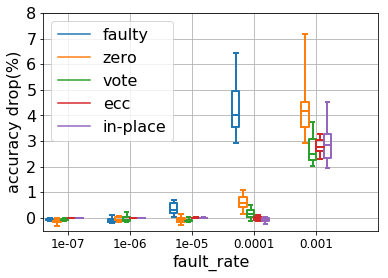

In [8]:
# x: fault_rate, y:accuracy; lengends: param_id 
def set_box_color(bp, color):
    linewidth = 2
    plt.setp(bp['boxes'], color=color, linewidth=linewidth)
    plt.setp(bp['whiskers'], color=color, linewidth=linewidth)
    plt.setp(bp['caps'], color=color, linewidth=linewidth)
    plt.setp(bp['medians'], color=color, linewidth=linewidth)
    
def print_accuracy(fault_type, fault_rates, accuracies):
    for a, b in zip(fault_rates, accuracies):
        b = ['%.2f' %(v) for v in b]
        bstr_format = '%6s '*len(b)
        print_format = '%10s %10s '+bstr_format
        print( print_format %(fault_type, a, *b))

# fault_types = ['faults_network_rb', 
#                'faults_network_rb_parity_zero', 'faults_network_rb_parity_avg',
#                'faults_network_rb_ps1', 
#                'faults_network_rb_adaptive']
def fault_type_to_legend(fault_type):
    d = {'faults_network_rb': 'faulty',
        'faults_network_rb_parity_zero': 'zero',
        'faults_network_rb_parity_avg': 'avg',
        'faults_network_rb_ps1': 'vote',
        'faults_network_rb_adaptive': 'adaptive',
         'faults_network_rb_ecc': 'ecc',
         'faults_network_rb_bch': 'bch'
        }
    return d[fault_type]
box_width = 0.6        
for model_type in data_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] 
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
              "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    n_space = len(fault_types)
    offset = -0.3*n_space
    print('%10s %10s %6s %6s %6s %6s %6s' 
          %('fault_type', 'fault_rate', '0', '1', '2', '3', '4'))
    
    box_id = 0 
    for i, fault_type in enumerate(fault_types):
        res = data[data_type][fault_type]
        if 'adaptive' in fault_type:
            # four options
#             # 1) lossy: key=(fault_rate, tier1_budgets, 0)
            keys = sorted(res.keys(), key=lambda x: x[0])
#             selected_keys = [] 
#             for key in keys:
#                 if key[1]=='tier1_budgets' and key[2]==0:
#                     selected_keys.append(key)
#             print('selected_keys', selected_keys)
#             fault_rates = [x[0] for x in selected_keys]
#             accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in selected_keys]
#             print_accuracy('(lossy)', fault_rates, accuracies)
#             bpl = plt.boxplot(accuracies, 
#                           positions=np.array(range(len(accuracies)))*n_space+offset, 
#                           sym='', widths=box_width, whis='range')
#             offset += 0.6
#             set_box_color(bpl, colors[box_id])
#             box_id += 1
            
            
            # 2) lossless ECC64: key=(fault_rate, tier1_budgets, 1)
            selected_keys = [] 
            for key in keys:
                if key[1]=='tier1_budgets' and key[2]==1:
                    selected_keys.append(key)
            print('selected_keys', selected_keys)
            fault_rates = [x[0] for x in selected_keys]
            accuracies = [sorted(fault_free_accuracy - res[fr][:, 2])[1:-1] for fr in selected_keys]
            print_accuracy('(ECC64)', fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                          positions=np.array(range(len(accuracies)))*n_space+offset, 
                          sym='', widths=box_width, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[box_id])
            box_id += 1
            
#             # 3) ECC32: key=(fault_rate, tier2_ECC_budgets, 0)
#             selected_keys = [] 
#             for key in keys:
#                 if key[1]=='tier2_ECC_budgets' and key[2]==0:
#                     selected_keys.append(key)
#             print('selected_keys', selected_keys)
#             fault_rates = [x[0] for x in selected_keys]
#             accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in selected_keys]
#             print_accuracy('(ECC32)', fault_rates, accuracies)
#             bpl = plt.boxplot(accuracies, 
#                           positions=np.array(range(len(accuracies)))*n_space+offset, 
#                           sym='', widths=box_width, whis='range')
#             offset += 0.6
#             set_box_color(bpl, colors[box_id])
#             box_id += 1
            
            
#             # 4) BCH: key=(fault_rate, tier2_BCH_budgets, 1)
#             selected_keys = [] 
#             for key in keys:
#                 if key[1]=='tier2_BCH_budgets' and key[2]==1:
#                     selected_keys.append(key)
#             print('selected_keys', selected_keys)
#             fault_rates = [x[0] for x in selected_keys]
#             accuracies = [fault_free_accuracy - res[fr][:, 2] for fr in selected_keys]
#             print_accuracy('(BCH)', fault_rates, accuracies)
#             bpl = plt.boxplot(accuracies, 
#                           positions=np.array(range(len(accuracies)))*n_space+offset, 
#                           sym='', widths=box_width, whis='range')
#             offset += 0.6
#             set_box_color(bpl, colors[box_id])
#             box_id += 1
            
        else:
            fault_rates = sorted(res.keys())
            accuracies = [sorted(fault_free_accuracy - res[fr][:, 2])[1:-1] for fr in fault_rates]
            print_accuracy(fault_type.split('_')[-1], fault_rates, accuracies)
            bpl = plt.boxplot(accuracies, 
                              positions=np.array(range(len(accuracies)))*n_space+offset, 
                              sym='', widths=box_width, whis='range')
            offset += 0.6
            set_box_color(bpl, colors[box_id])
            box_id += 1


    # draw temporary red and blue lines and use them to create a legend
    box_id = 0 
    for i, fault_type in enumerate(fault_types):
        if 'adaptive' in fault_type:
#             plt.plot([], c=colors[box_id], label='(Lossy)')
#             box_id += 1
            plt.plot([], c=colors[box_id], label='in-place')
            box_id += 1
#             plt.plot([], c=colors[box_id], label='(ECC32)')
#             box_id += 1
#             plt.plot([], c=colors[box_id], label='(BCH)')
#             box_id += 1
        else:
            plt.plot([], c=colors[box_id], label=fault_type_to_legend(fault_type))
            box_id += 1
            
            
    fontsize = 16 
    x = range(0, len(fault_rates) * n_space, n_space)
    plt.xticks(x, [str(fault_rate) for fault_rate in fault_rates])

    plt.xlim(-2, len(fault_rates)*n_space)
    if model_name == 'vgg16':
        plt.ylim(-0.5, 2)
    if model_name == 'resnet18':
        plt.ylim(-0.5, 8)
    if model_name == 'squeezenet':
        plt.ylim(-0.5, 16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=fontsize)
    plt.grid()
    plt.ylabel('accuracy drop(%)', fontsize=fontsize)
    plt.xlabel('fault_rate', fontsize=fontsize)
#     plt.plot(x, [fault_free_accuracy]*len(x), color='k', linestyle='--',
#              label='fault-free:%.2f%%' %(fault_free_accuracy))   
    plt.legend(loc=2, fontsize=16)
#     plt.show()
    figdir = './figures/accuracy_drop/'
    figname = model_name+'_int8_accuracy_drop.pdf'
    plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')


In [8]:
# # print out mean and variance under different fault rate for adaptive encoding 
# precision = 2
# # strategy, faulty, zero, avg, vote, ecc, adaptive 
# import json 
# def load_configs(configs):
#     steps_path = os.path.join('./logs', model_name, 'imagenet', 'int8', 'gradual_encoding_adaptive')
#     print('load configs from path:', steps_path) 
#     with open(os.path.join(steps_path, configs), 'r') as f:
#         configs = json.load(f)
#     return configs 

# configs_dict = {'tier1_budgets': load_configs('tier1_budgets.json'),
#            'tier2_ECC_budgets': load_configs('tier2_ECC_budgets.json'),
#            'tier2_BCH_budgets': load_configs('tier2_BCH_budgets.json')
#           }

# print('%10s %10s %6s %10s %15s' %('strategy', 'r', 'budget', 'overhead', 'mean'))

# for model_type in data_types:
#     fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
#     for i, fault_type in enumerate(fault_types):
#         res = data[data_type][fault_type]
        
        
#         if 'adaptive' in fault_type:
#             # key format: (fault_rate, tier1_budgets/tier2*, config_id)
#             keys = sorted(res.keys(), key=lambda x: (x[1], x[2], x[0]))
            
#             # select only tier1, config_id = 0
#             keys = [k for k in keys if k[1] == 'tier1_budgets' and k[2] == 1 and k[0] >= 1e-6]
            
# #             tmp = np.array(sorted(fault_free_accuracy - res[fr][:, 2])[1:-1])
#             accuracies = [(round(np.mean(np.array(sorted(fault_free_accuracy - res[fr][:, 2])[1:-1])), precision),
#                        round(np.std(np.array(sorted(fault_free_accuracy - res[fr][:, 2])[1:-1])), precision)) 
#                           for fr in keys]
            
#             for key, item in zip(keys, accuracies):
#                 configs = configs_dict[key[1]]
#                 budget = round(configs[int(key[-1])]['target_budget'], precision)
#                 overhead = round(configs[int(key[-1])]['budget'], precision)
#                 print('%10s %10s %6s %10s %15s'
#                       %(key[1].split('_')[1], key[0], budget, overhead, str(item[0])+' $\pm$ '+str(item[1])))
                    
#         else:
#             keys = sorted(res.keys())
#             keys = [k for k in keys if float(k) >= 1e-6]
            
            
#             accuracies = [(round(np.mean(np.array(sorted(fault_free_accuracy - res[fr][:, 2])[1:-1])), precision),
#                        round(np.std(np.array(sorted(fault_free_accuracy - res[fr][:, 2])[1:-1])), precision)) 
#                           for fr in keys]
#             for key, item in zip(keys, accuracies):
#                 print('%10s %10s %6s %10s %15s'
#                       %(fault_type_to_legend(fault_type), key, '-', '-', str(item[0])+' $\pm$ '+str(item[1])))
        
           
      



In [10]:
# import pickle 
# def load_pickle(load_path, load_name=None, verbose=False):
#     if load_name:
#         filepath =  os.path.join(load_path, load_name)
#     else:
#         filepath = load_path 
#     if verbose:
#         print('Load pickle file:', filepath)
#     return pickle.load( open(filepath, "rb" ))

# # def parse_stats_dict(stats):
# #     # input format:
# #     # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
# #     # output format: 
# #     # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
# #     param_stats = {'changed_params':0, 
# #                    'flip_to_one': np.zeros(8, dtype='int'), 
# #                    'flip_to_zero': np.zeros(8, dtype='int'),
# #                   'value_before_flip': [],
# #                   'value_after_flip':[], 
# #                   'flipped_positions': []}
# #     for weight_id, value_dict in stats.items():       
# #         for value_id, flip_list in value_dict.items():
# #             param_stats['changed_params'] += 1
# #             param_stats['value_before_flip'].append(flip_list[0][0])
# #             param_stats['value_after_flip'].append(flip_list[-1][-1])
# #             param_stats['flipped_positions'].append([x[1] for x in flip_list])

# #             for _, flip_pos, flip_bit, flip_value in flip_list:
# #                 if flip_bit:
# #                     param_stats['flip_to_one'][flip_pos] += 1
# #                 else:
# #                     param_stats['flip_to_zero'][flip_pos] += 1
# #     return param_stats 

# def parse_stats(stats):
#     param_stats = {'changed_params':0, 
#                    'flip_to_one': np.zeros(8, dtype='int'), 
#                    'flip_to_zero': np.zeros(8, dtype='int'),
#                   'value_before_flip': [],
#                   'value_after_flip':[], 
#                    'value_after_correction':[],
#                   'flipped_positions': []}
#     for weight_id, value_tuple in stats.items(): 
#         if isinstance(value_tuple, tuple):
#             value_dict, corr_dict = value_tuple 
#         else:
#             value_dict, corr_dict = value_tuple, None 
        
#         for value_id, flip_list in value_dict.items():
#             param_stats['changed_params'] += 1
#             param_stats['value_before_flip'].append(flip_list[0][0])
#             param_stats['value_after_flip'].append(flip_list[-1][-1])
#             param_stats['flipped_positions'].append([x[1] for x in flip_list])
            
#             if corr_dict:
#                 if value_id in corr_dict:
#                     assert corr_dict[value_id][0] == flip_list[-1][-1]
#                     param_stats['value_after_correction'].append(corr_dict[value_id][-1])
#                 else:
#                     param_stats['value_after_correction'].append(flip_list[-1][-1])

#             for _, flip_pos, flip_bit, flip_value in flip_list:
#                 if flip_bit:
#                     param_stats['flip_to_one'][flip_pos] += 1
#                 else:
#                     param_stats['flip_to_zero'][flip_pos] += 1
#     return param_stats 

# def trial_id_to_stats_files(trial_id):
#     return str(trial_id)+'.pkl' 

# def load_and_average_stats(results_dir, trial_ids):
#     stat_dir = os.path.join(results_dir, 'stats')
#     stats_files = map(trial_id_to_stats_files, trial_ids)
#     avg_param_stats = None 
#     for f in stats_files:
#         # each trial is saved as a pickle 
#         stats = load_pickle(stat_dir, f, verbose=False)
#         for item in stats:
#             print(item, stats[item])
#         param_stats = parse_stats(stats)
#         if avg_param_stats:
#             for key, value in param_stats.items():
#                 avg_param_stats[key] += value 
#         else:
#             avg_param_stats = param_stats
#     return avg_param_stats
                    

In [11]:

# model_type = 'int8'
# fault_rate = 1e-6
# target_accuracy = 0
# markers = ['o', '+']
# for fi, fault_type in enumerate(fault_types):
#     print('\nfault_type:', fault_type)
    
#     if 'inplace' in fault_type:
#         folder = 'r%s/%.2f' %( fault_rate, target_accuracy)
#         print('accuracies:', data[model_type][fault_type][(fault_rate, target_accuracy)][:, 2])
#     else:
#         folder = 'r%s' %(fault_rate)
#         print('accuracies:', data[model_type][fault_type][fault_rate][:, 2])
#     results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

#     avg_params_stats = load_and_average_stats(results_dir, [0])
#     # print(avg_params_stats)
#     print('flip_to_one: %s, flip_to_zero: %s' 
#           %(avg_params_stats['flip_to_one'], avg_params_stats['flip_to_zero']))
    
#     print('#changed_values:', len(avg_params_stats['value_before_flip']), 
#           ', #flipped_bits:', sum(avg_params_stats['flip_to_one'])+sum(avg_params_stats['flip_to_zero']),
#          ', #changed_values:', len(avg_params_stats['flipped_positions']),
#          ', #flipped_bits:',sum([len(x) for x in avg_params_stats['flipped_positions']]))
    
# #     num_values_show = 100 
# #     print(list(zip(avg_params_stats['value_before_flip'][:num_values_show], 
# #                    avg_params_stats['flipped_positions'][:num_values_show],
# #                    avg_params_stats['value_after_flip'][:num_values_show])))

# #     check = [(avg_params_stats['value_before_flip'][i], 
# #                   avg_params_stats['flipped_positions'][i], 
# #                  avg_params_stats['value_after_flip'][i]) 
# #              for i, item in enumerate(avg_params_stats['flipped_positions'])
# #                                      if (0 in item or 1 in item or 2 in item) and 
# #             avg_params_stats['value_before_flip'][i]!=avg_params_stats['value_after_flip'][i]]
# #     print(len(check), check)
    
# #     plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 
# #              marker=markers[fi%2], label=fault_type, linestyle='')
# #     plt.xlabel('value_before_flip')
# #     plt.ylabel('value_after_flip')
    
    
# # plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
# # plt.legend()
# # plt.title('fault_rate: %s' %(fault_rate))
# # plt.show()

# import collections 
# counter = collections.Counter([x for y in avg_params_stats['flipped_positions'] for x in y ])
# counts = sorted(counter.items(), key=lambda x: x[0])
# counts = list(zip(*counts))
# plt.bar(counts[0], counts[1])
# plt.show()
             
                               

In [12]:
# import torch 

# model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = checkpoint['prec1']
# print('prec1:', prec1)
# state_dict = checkpoint['state_dict']
# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     plt.hist(tensor.cpu().numpy().ravel(), bins=100)
#     plt.title(key+' [%d, %d]' %(minv, maxv))
#     plt.show()